In [1]:
import sys
import os

import json
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Resize
import torch.nn.functional as F

from datasets import Dataset, Features, Value
from datasets import Image as HFImage
from transformers import AutoImageProcessor, AutoModel

/Users/mar-sangineto/Documents/sorbonne/cours/deepL/projet/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### to import local funtions

ATENTION: You may have to change the path so that this can run on your device

In [2]:
# Checks on which folder the notebook is initially running
os.getcwd()

'/Users/mar-sangineto/Documents/sorbonne/cours/deepL/projet/OADino'

In [3]:
# Change according to where are you running so that the final path contains oadino

PROJECT_FOLDER_PATH = os.getcwd() # initial path + relative path to OADino
PROJECT_FOLDER_PATH

'/Users/mar-sangineto/Documents/sorbonne/cours/deepL/projet/OADino'

In [4]:
sys.path.append(PROJECT_FOLDER_PATH)

Internal imports

In [5]:
# from oadino.models import OADinoModel, OADinoPreProcessor, ConvVAE16
from oadino.models import OADinoModel, OADinoPreProcessor, ConvVAE16
from oadino.training import get_preprocessed_data, vae_loss

#### Settup device

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu


### Dataset loading

In [7]:
# # loading CLEVR dataset avaliable on https://cs.stanford.edu/people/jcjohns/clevr/


# # loading CLEVRtex dataset avaliable on https://www.robots.ox.ac.uk/~vgg/data/clevrtex/#downloads

# # loading Stanford dataset avaliable on https://huggingface.co/datasets/tanganke/stanford_cars
# # Load the dataset in a tabular format with image URLs and metadata
# cars_dataset = load_dataset("tanganke/stanford_cars")

# # Access the training set directly
# cars_train_set = dataset["train"]

In [8]:
#from training_loop_initial_testing import create_hf_dataset

def create_hf_dataset(image_dir, maxsize=-1):
    image_paths = sorted(Path(image_dir).glob("*.png"))

    # Create dataset dict
    data_dict = {
        "image": [str(p) for p in image_paths[:maxsize]],
        "filename": [p.name for p in image_paths[:maxsize]],
    }

    dataset = Dataset.from_dict(
        data_dict,
        features=Features(
            {
                "image": HFImage(),
                "filename": Value("string"),
            }
        ),
    )

    return dataset

def transform_batch(batch):
    batch["image"] = [transform(img.convert("RGB")) for img in batch["image"]]
    return batch



In [9]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

CLEVR

In [10]:
DATA_PATH = "../data/"

train_data_path = Path(DATA_PATH + "/CLEVR_v1.0/images/train")
test_data_path = Path(DATA_PATH + "/CLEVR_v1.0/images/test")

train_dataset = create_hf_dataset(train_data_path, maxsize=4096)
test_dataset = create_hf_dataset(test_data_path, maxsize=4096)

train_dataset = train_dataset.with_transform(transform_batch)
train_dataset_name = "CLEVR_train_4K_224"
test_dataset_name  = f"{train_dataset_name}_test"
test_dataset = test_dataset.with_transform(transform_batch)


In [11]:
Path(DATA_PATH + "/CLEVR_v1.0/images/train").exists()

True

In [12]:
Path(test_data_path).exists()

True

In [13]:
train_pngs = sorted(train_data_path.glob("*.png"))
test_pngs  = sorted(test_data_path.glob("*.png"))

print("#train png:", len(train_pngs), "first:", train_pngs[0] if train_pngs else None)
print("#test  png:", len(test_pngs),  "first:", test_pngs[0] if test_pngs else None)

#train png: 70000 first: ../data/CLEVR_v1.0/images/train/CLEVR_train_000000.png
#test  png: 15000 first: ../data/CLEVR_v1.0/images/test/CLEVR_test_000000.png


In [14]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Data visualization

## Models

In [15]:
## Loading Backbone Models
hf_cache = Path("../data/")

dino_processor = AutoImageProcessor.from_pretrained(
    "facebook/dinov2-small", cache_dir=hf_cache
)
dino_model = AutoModel.from_pretrained("facebook/dinov2-base", cache_dir=hf_cache).to(device)

The image processor of type `BitImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
Loading weights: 100%|██████████| 223/223 [00:00<00:00, 1634.06it/s, Materializing param=layernorm.weight]                                 


In [16]:
pre_processor = OADinoPreProcessor(dino_processor, dino_model)
vae = ConvVAE16()
model = OADinoModel(vae)

## Preprocessing OADino

visualizing the segmentations and patches

In [17]:
model_folder = pre_processor.backbone.config.name_or_path.replace("/", "_")
savedir = Path(hf_cache) / test_dataset_name / model_folder
print("Expected preprocess folder:", savedir)
print("Contains:", list(savedir.glob("*"))[:10])


Expected preprocess folder: ../data/CLEVR_train_4K_224_test/facebook_dinov2-base
Contains: []


In [ ]:
import shutil

model_folder = pre_processor.backbone.config.name_or_path.replace("/", "_")

train_savedir = Path(hf_cache) / train_dataset_name / model_folder
test_savedir  = Path(hf_cache) / f"{train_dataset_name}_test" / model_folder

def delete_if_empty(savedir):
    meta = savedir / "metadata.json"
    if meta.exists():
        m = json.loads(meta.read_text())
        print(savedir, "actual_samples:", m.get("actual_samples"))
        if m.get("actual_samples", 0) == 0:
            print("Deleting bad cache:", savedir)
            shutil.rmtree(savedir)

delete_if_empty(train_savedir)
delete_if_empty(test_savedir)


In [ ]:
debug_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
batch = next(iter(debug_loader))

with torch.no_grad():
    feats, patches, masks = pre_processor.get_global_features_and_patches(batch["image"], pca_q=None, pca_niter=2)

print("feats:", feats.shape)
print("patches:", patches.shape)
print("masks:", masks.shape, masks.dtype)
print("foreground per image:", masks.sum(dim=1))


feats: torch.Size([4, 768])
patches: torch.Size([4, 256, 3, 14, 14])
masks: torch.Size([4, 256]) torch.bool
foreground per image: tensor([113, 132, 148, 119])


In [21]:
preprocessed_train_dataset = get_preprocessed_data(
    dataset = train_dataset,
    dataset_name = train_dataset_name,
    image_size=224,
    preprocessor=pre_processor,
    base_dir=hf_cache,
    batch_size=64
)

Found directory ../data/CLEVR_train_4K_224/facebook_dinov2-base but could not load dataset
Metadata file not found at ../data/CLEVR_train_4K_224/facebook_dinov2-base/metadata.json. Make sure the dataset was finalized properly.
Data will be reprocessed
Processing 4096 samples...
Saving to: ../data/CLEVR_train_4K_224/facebook_dinov2-base


Batches: 100%|██████████| 64/64 [15:27<00:00, 14.49s/it]

Finalizing dataset...
Dataset saved to ../data/CLEVR_train_4K_224/facebook_dinov2-base
Total samples processed: 4096


In [22]:
preprocessed_test_dataset = get_preprocessed_data(
    dataset=test_dataset,
    dataset_name=test_dataset_name,
    image_size=224,
    preprocessor=pre_processor,
    base_dir=hf_cache,
    batch_size=64
)

Processing 4096 samples...
Saving to: ../data/CLEVR_train_4K_224_test/facebook_dinov2-base


Batches: 100%|██████████| 64/64 [16:35<00:00, 15.56s/it]

Finalizing dataset...
Dataset saved to ../data/CLEVR_train_4K_224_test/facebook_dinov2-base
Total samples processed: 4096


In [23]:
print("len(preprocessed_train_dataset):", len(preprocessed_train_dataset))
print("len(preprocessed_test_dataset):", len(preprocessed_test_dataset))

len(preprocessed_train_dataset): 4096
len(preprocessed_test_dataset): 4096


In [24]:
test_loader = DataLoader(preprocessed_test_dataset, batch_size=64, shuffle=False, num_workers=0)

### From the training...

#### Training configutations

In [25]:
config_path = PROJECT_FOLDER_PATH + "/runs/CLEVR_train_4K_224_20260202_210355/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
    
for configuration in config:
    print(configuration, "=", config[configuration])

dataset_name = CLEVR_train_4K_224
model_name = OADinoModel
num_epochs = 10
learning_rate = 0.001
train_batch_size = 64
test_batch_size = 64
loss_beta = 0.0001
image_size = 224
device = cpu


### loading model

visualizing the final trained VAE

In [26]:
checkpoints_dir = "./runs/CLEVR_train_4K_224_20260202_210355/checkpoints/"
checkpoints_dir = Path(checkpoints_dir)
best_checkpoint_path = checkpoints_dir / "best_model.pt"
final_checkpoint_path = checkpoints_dir / "final_model.pt"

In [27]:
best_checkpoint = torch.load(best_checkpoint_path, map_location=device)
final_checkpoint = torch.load(final_checkpoint_path, map_location=device)

best_model = OADinoModel(ConvVAE16()).to(device)
final_model = OADinoModel(ConvVAE16()).to(device)


best_model.load_state_dict(best_checkpoint["model_state_dict"])
final_model.load_state_dict(final_checkpoint["model_state_dict"])

<All keys matched successfully>

In [28]:
final_model.eval()

OADinoModel(
  (vae): ConvVAE16(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (mean_layer): Sequential(
      (0): Linear(in_features=1024, out_features=32, bias=True)
    )
    (logvar_layer): Sequential(
      (0): Linear(in_features=1024, out_features=32, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
     

# eval

In [29]:
@torch.no_grad()
def evaluate_model(model, loader, device, loss_beta=1e-4):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n_batches = 0

    vae_in = model.vae.input_size
    resize_transform = Resize((vae_in, vae_in))

    for batch in loader:
        patches = batch["patches"].to(device)             # (B, P, 3, ps, ps)
        masks   = batch["masks"].to(device).bool()        # (B, P)
        flat_patches = resize_transform(patches.flatten(0, 1))  # (B*P, 3, vae_in, vae_in)
        flat_masks   = masks.flatten()                         # (B*P,)

        # Forward: only masked patches go through VAE
        x_hat, mean, logvar = model.encode_decode_object_patches(flat_patches, flat_masks)

        # Loss is computed against the masked originals
        loss, recon, kl = vae_loss(
            flat_patches[flat_masks],
            x_hat, mean, logvar,
            loss_beta,
            return_components=True,
        )

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        n_batches += 1

    return {
        "loss": total_loss / n_batches,
        "recon": total_recon / n_batches,
        "kl": total_kl / n_batches,
    }

loss_beta = config.get("loss_beta", 1e-4)  # from loaded config.json
best_metrics  = evaluate_model(best_model,  test_loader, device, loss_beta=loss_beta)
final_metrics = evaluate_model(final_model, test_loader, device, loss_beta=loss_beta)

print("BEST :", best_metrics)
print("FINAL:", final_metrics)


BEST : {'loss': 3.9315133206546307, 'recon': 3.9315128438174725, 'kl': 0.003606314021453727}
FINAL: {'loss': 3.931513302028179, 'recon': 3.931512825191021, 'kl': 0.003606314021453727}


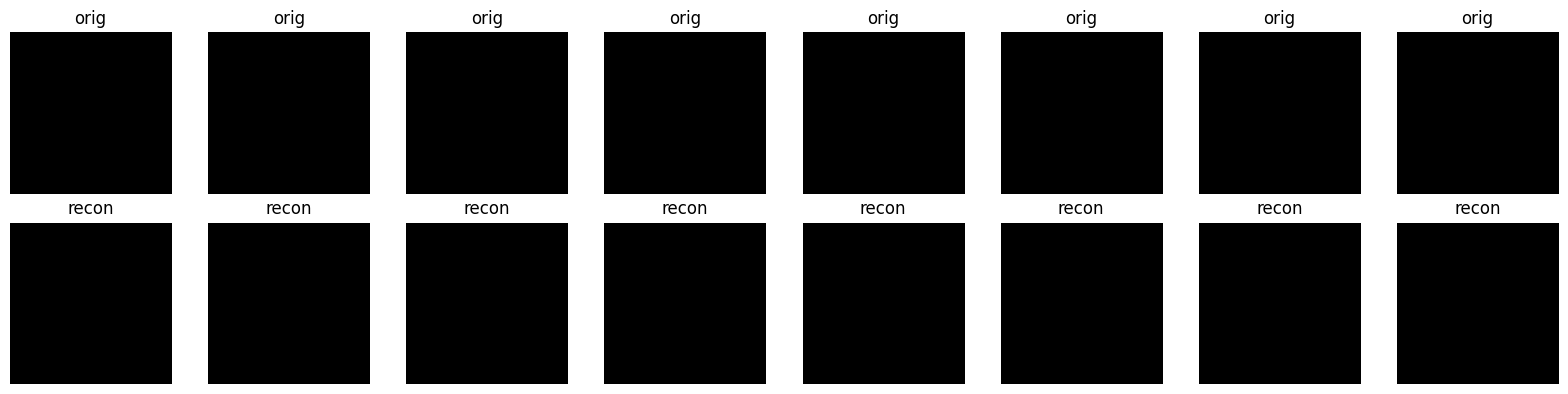

In [30]:
@torch.no_grad()
def show_reconstructions(model, dataset, device, n_show=8, seed=0):
    model.eval()
    g = torch.Generator().manual_seed(seed)

    idx = torch.randint(0, len(dataset), (1,), generator=g).item()
    sample = dataset[idx]
    patches = sample["patches"].to(device)      # (P, 3, ps, ps)
    masks   = sample["masks"].to(device).bool() # (P,)

    # pick some foreground patches
    fg_idx = torch.where(masks)[0]
    if len(fg_idx) == 0:
        print("No foreground patches in this sample.")
        return

    fg_idx = fg_idx[:n_show]
    x = patches[fg_idx]  # (n_show, 3, ps, ps)

    # run through model (expects flat inputs)
    vae_in = model.vae.input_size
    resize_transform = Resize((vae_in, vae_in))
    x_in = resize_transform(x)

    x_hat, _, _ = model.vae(x_in)

    # plot
    n = x.shape[0]
    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        axes[0, i].imshow(x[i].permute(1,2,0).detach().cpu().clamp(0,1))
        axes[0, i].axis("off")
        axes[0, i].set_title("orig")

        axes[1, i].imshow(x_hat[i].permute(1,2,0).detach().cpu().clamp(0,1))
        axes[1, i].axis("off")
        axes[1, i].set_title("recon")
    plt.tight_layout()
    plt.show()

show_reconstructions(best_model, preprocessed_test_dataset, device, n_show=8, seed=0)


In [31]:
@torch.no_grad()
def compute_oadino_features(model, loader, device):
    """
    Returns:
      per_image_feats: list[Tensor] length N, each Tensor is (n_fg_patches, dim)
      pooled_feats: Tensor (N, dim) L2-normalized mean pooling (for fast coarse search)
    """
    model.eval()
    per_image = []
    pooled = []

    for batch in loader:
        global_feats = batch["features"].to(device)        # (B, ng)
        patches      = batch["patches"].to(device)         # (B, P, 3, ps, ps)
        masks        = batch["masks"].to(device).bool()    # (B, P)

        flat_patches = patches.flatten(0, 1)               # (B*P, 3, ps, ps)
        flat_masks   = masks.flatten()                     # (B*P,)

        # local object features for masked patches only
        _, mean, _ = model.encode_decode_object_patches(flat_patches, flat_masks)  # mean is (n_masked, nl)
        # combine global+local per image (list of tensors)
        feats_list = model.get_features(global_feats, mean, masks)

        for fi in feats_list:
            per_image.append(fi.detach().cpu())
            if fi.numel() == 0:
                pooled.append(torch.zeros((fi.shape[-1],), dtype=torch.float32))
            else:
                pooled.append(fi.mean(dim=0).float())

    pooled = torch.stack(pooled, dim=0)
    pooled = F.normalize(pooled, dim=1)
    return per_image, pooled

@torch.no_grad()
def patch_similarity(query_feats, cand_feats):
    """
    query_feats: (nq, d)
    cand_feats : (nc, d)
    returns scalar similarity
    """
    if query_feats.numel() == 0 or cand_feats.numel() == 0:
        return -1e9
    q = F.normalize(query_feats, dim=1)
    c = F.normalize(cand_feats, dim=1)
    sim = q @ c.T                      # (nq, nc)
    return sim.max(dim=1).values.mean().item()

# Build features once
feat_loader = DataLoader(preprocessed_test_dataset, batch_size=64, shuffle=False, num_workers=0)
per_img_feats, pooled = compute_oadino_features(best_model, feat_loader, device)

def retrieve(query_idx, topk=10, shortlist=200):
    q_pool = pooled[query_idx:query_idx+1]          # (1, d)
    coarse = (q_pool @ pooled.T).squeeze(0)         # (N,)
    topL = torch.topk(coarse, k=min(shortlist, len(coarse))).indices.tolist()

    q_feats = per_img_feats[query_idx]
    scored = []
    for j in topL:
        s = patch_similarity(q_feats, per_img_feats[j])
        scored.append((s, j))
    scored.sort(reverse=True)
    return scored[:topk]

# Example
query_idx = 0
results = retrieve(query_idx, topk=8, shortlist=200)
print("Top results:", results[:5])


IndexError: The shape of the mask [64, 256] at index 0 does not match the shape of the indexed tensor [8192, 32] at index 0